In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
plt.style.use('seaborn-v0_8')

## Training data

In [2]:
df  = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')
df.sample(5)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
6598,India Cried That Night: Untold Tales of Freedo...,Supratim Sarkar,"Paperback,– 20 Aug 2018",5.0 out of 5 stars,3 customer reviews,"Kanailal Bhattacharya, nineteen, calmly walks ...",Action & Adventure (Books),Action & Adventure,2.640
1473,Creative Selection: Inside Apple's Design Proc...,Ken Kocienda,"Paperback,– 6 Sep 2018",4.7 out of 5 stars,7 customer reviews,An insider's account of Apple's creative proce...,Design,"Arts, Film & Photography",3.720
1107,The Woman in the Window: A Novel,A. J. Finn,"Hardcover,- 2018",4.4 out of 5 stars,38250.0 customer reviews,NaN,Fiction,Fiction,14.180
6623,The Film Sense (Harvest/Hbj Book),Sergei Eisenstein,"Paperback,– 31 Dec 1998",5.0 out of 5 stars,1 customer review,A renowned Soviet director discusses his theor...,Cinema & Broadcast (Books),"Arts, Film & Photography",14.136
5671,America the Beautiful: Rediscovering What Made...,Ben Carson M.D.,"Paperback,- 2013",4.8 out of 5 stars,3826.0 customer reviews,NaN,Non Fiction,Non Fiction,10.610


I started off by importing the necessary libraries and reading in the data. I then took a look at the data to see what I was working with.

This is clearly a regression problem as we are trying to predict a continuous variable which is the price of the books.

In [3]:
df.shape

(6823, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6822 non-null   object 
 1   Author        6822 non-null   object 
 2   Edition       6823 non-null   object 
 3   Reviews       6823 non-null   object 
 4   Ratings       6823 non-null   object 
 5   Synopsis      5808 non-null   object 
 6   Genre         6822 non-null   object 
 7   BookCategory  6419 non-null   object 
 8   Price         6823 non-null   float64
dtypes: float64(1), object(8)
memory usage: 479.9+ KB


#### The dataframe consists of 6823 rows and 9 columns. The columns are as follows:
- Title: The title of the book
- Author: The author(s) of the book
- Edition: The edition of the book eg (Paperback,–26 Apr 2018)
- Reviews: The customer reviews about the book
- Ratings: The number of customer ratings about the book
- Synopsis: The synopsis of the book
- Genre: The genre the book belongs to
- BookCategory: The department the book belongs to
- Price: The price of the book (Target variable)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,6823.0,13.471419,25.174514,0.0,3.588,5.868,13.465,886.08


#### I've noticed a few things from the description of the price column
- First is that the minimum price is 0 which cannot be True 
- Second is that the maximum price is 886.08 which is an outlier in regards of the mean, median and percentiles
  
So we will have to deal with those issues later in the notebook

In [6]:
df.isnull().sum()

Title              1
Author             1
Edition            0
Reviews            0
Ratings            0
Synopsis        1015
Genre              1
BookCategory     404
Price              0
dtype: int64

#### From this cell we can see that there are:
- One missing value in each of the Title, Author and Genre coulmns
- 1015 missing values in the synopsis coulmn
- 404 missing values in the BookCategory coulmn
  
We will decide what to do with them later on in the notebook

In [7]:
df.duplicated().sum()

205

There are 205 duplicated rows so I will drop them 

In [8]:
df.drop_duplicates(inplace= True , ignore_index= True)

Befor starting in the cleaning process I will drop the columns that will not be beneficial to the model  

In [9]:
df['Title'][0]

'Jesse James (Lucky Luke)'

In [10]:
df['Synopsis'][0]

'Cowboy Lucky Luke upholds the law of the Wild West. Always accompanied by his loyal and dapper horse Jolly Jumper, Lucky dedicates his life to serving justice—and beating his bumbling but persistent foes, the Dalton brothers.\n This adventure pits Lucky Luke against Jessie James, a self-styled Robin Hood who robs the rich—and keeps the cash.'

##### These two columns ; Title and Synopsis do not provide any information beneficial to the model so I will drop them

In [11]:
df.drop(columns=['Title', 'Synopsis'], inplace=True)

Now let's head the data again to see what we have

In [12]:
df.head()

,Author,Edition,Reviews,Ratings,Genre,BookCategory,Price
0,"Rene Goscinny, Jean Tarbary","Paperback,– Import, 1 Apr 2008",5.0 out of 5 stars,1 customer review,Comics & Mangas (Books),Comics & Mangas,2.292
1,George R. R. Martin,"Paperback,– 27 Mar 2014",4.5 out of 5 stars,474 customer reviews,Action & Adventure (Books),"Crime, Thriller & Mystery",4.800
2,Eleanor Winters,"Paperback,– 28 May 2000",4.9 out of 5 stars,15 customer reviews,"Handicrafts, Decorative Arts & Crafts (Books)","Arts, Film & Photography",10.500
3,Zlatan Ibrahimovic,"Paperback,– 24 Sep 2013",4.8 out of 5 stars,52 customer reviews,Biographies & Autobiographies (Books),Sports,5.520
4,Connelly Clare,"Paperback,– 28 Jul 2017",4.5 out of 5 stars,2 customer reviews,Romance (Books),Romance,4.776


### Data Cleaning

#### Price column

Let's head the data again to see what we have

In [13]:
df.head()

,Author,Edition,Reviews,Ratings,Genre,BookCategory,Price
0,"Rene Goscinny, Jean Tarbary","Paperback,– Import, 1 Apr 2008",5.0 out of 5 stars,1 customer review,Comics & Mangas (Books),Comics & Mangas,2.292
1,George R. R. Martin,"Paperback,– 27 Mar 2014",4.5 out of 5 stars,474 customer reviews,Action & Adventure (Books),"Crime, Thriller & Mystery",4.800
2,Eleanor Winters,"Paperback,– 28 May 2000",4.9 out of 5 stars,15 customer reviews,"Handicrafts, Decorative Arts & Crafts (Books)","Arts, Film & Photography",10.500
3,Zlatan Ibrahimovic,"Paperback,– 24 Sep 2013",4.8 out of 5 stars,52 customer reviews,Biographies & Autobiographies (Books),Sports,5.520
4,Connelly Clare,"Paperback,– 28 Jul 2017",4.5 out of 5 stars,2 customer reviews,Romance (Books),Romance,4.776


Let's see the description of the price column

In [14]:
df['Price'].describe()

count    6618.000000
mean       12.608326
std        24.452124
min         0.000000
25%         3.588000
50%         5.688000
75%        12.694500
max       886.080000
Name: Price, dtype: float64

There seems to be some outliers in the price column so I will plot it to make sure

<Axes: xlabel='Price'>

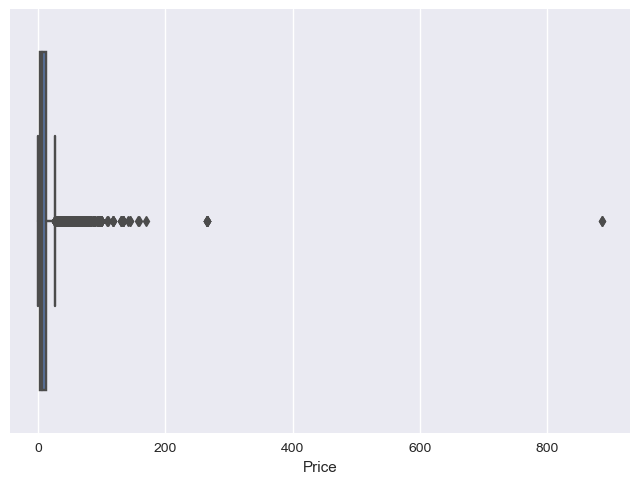

In [15]:
sns.boxplot(x = df['Price'], data=df)

As we expected there are some outliers in the price column so I will replace them with the median

In [16]:
df['Price'] = [x if x < 100 else df['Price'].median() for x in df['Price']]

Let's now take a look at the distribution of the price column

<Axes: xlabel='Price', ylabel='Count'>

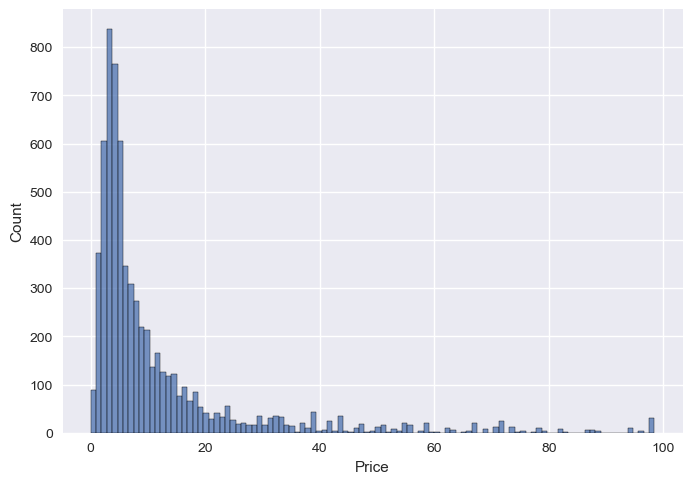

In [17]:
sns.histplot(x = df['Price'], data=df)

There are some values that equal to 0 which is not possible so I will replace them with the median

In [18]:
df['Price'] = [x if x > 0 else df['Price'].median() for x in df['Price']]

In [19]:
df['Price'].describe()

count    6618.000000
mean       11.641151
std        15.561257
min         0.170000
25%         3.588000
50%         5.688000
75%        12.456000
max        98.420000
Name: Price, dtype: float64

Everything looks fine for now

#### Edition column

I've noticed that the edition column has two parts, the first part is the type of the edition (Paperback, Hardcover, etc) and the second part is the date of the edition

I will split the column into two columns, one for the type and the other for the date

In [20]:
df[['Edition_type', 'Edition_year']] = df['Edition'].str.split(' ',1, expand=True)

C:\Users\Abdul\AppData\Local\Temp\ipykernel_9832\800193324.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['Edition_type', 'Edition_year']] = df['Edition'].str.split(' ',1, expand=True)


I Will use regex to extract only the type from the edition type column

In [21]:
df['Edition_type'] = [re.sub(r'[^a-zA-Z]', '', i) for i in df['Edition_type']]

Then I will use regex to extract only the year from the new edition year column

In [22]:
df['Edition_year'] = [re.findall(r'(\d+)(?!.*\d)', str(i)) for i in df['Edition_year']]
df['Edition_year'] = df['Edition_year'].apply(lambda x: int(x[0]) if len(x)>0 else 0)

And now i will drop the edition column

In [23]:
df.drop(columns=['Edition'], inplace=True)

Let's check if there are any missing values in the new columns

In [24]:
df[['Edition_type', 'Edition_year']].isnull().sum()

Edition_type    0
Edition_year    0
dtype: int64

Looks like there are no missing values in the new columns

Lets check the value counts in the type column

In [25]:
df['Edition_type'].value_counts().head()

Paperback    4392
Hardcover    1171
Mass          142
Oct           134
Nov            87
Name: Edition_type, dtype: int64

The two most common types are Paperback and Hardcover so I will replace the other types with others

In [26]:
types = ['Paperback','Hardcover']
df['Edition_type'] = df['Edition_type'].apply(lambda x: 'Others' if x not in types else x)

In [27]:
df['Edition_type'].value_counts()

Paperback    4392
Hardcover    1171
Others       1055
Name: Edition_type, dtype: int64

<Axes: xlabel='Edition_type', ylabel='Price'>

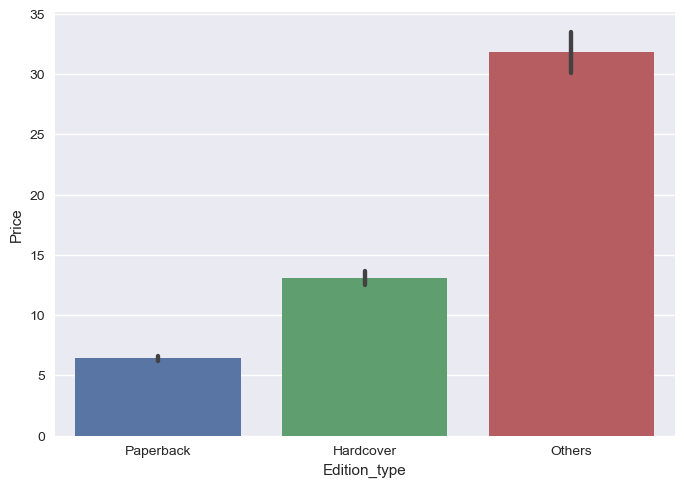

In [28]:
sns.barplot(x = df['Edition_type'], y = df['Price'], data = df)

Now let's check the unique values in the year column

In [29]:
df['Edition_year'].unique()

array([2008, 2014, 2000, 2013, 2017, 2016, 2012, 2018, 2007, 2019, 2011,
       2003, 1999, 2009, 2015, 2010, 2002, 2006, 1992, 1998, 2005, 2021,
       1990, 1982, 2001, 1971, 2020, 1991, 1995, 1985, 1969, 1986, 1989,
       1994, 1996, 1979, 1997, 2004, 1993, 1983, 1988,    0, 1977, 1987,
       1975, 1974, 1964, 1978, 1984, 1976, 1961, 1980, 1970, 1900, 1981,
       1973, 1925, 1960], dtype=int64)

<Axes: xlabel='Edition_year', ylabel='count'>

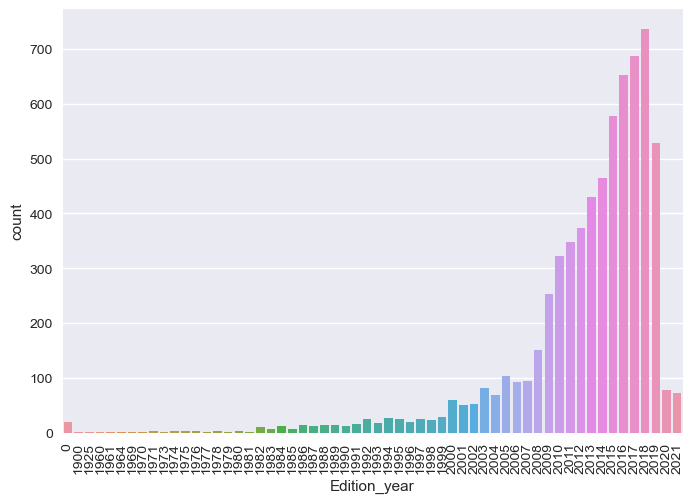

In [30]:
plt.xticks(rotation=90)
sns.countplot(x = df['Edition_year'], data=df)

Everything looks good so far except for the 0 value which is not possible so I will replace it with the most common year

In [31]:
df['Edition_year'].value_counts().head()

2018    736
2017    688
2016    652
2015    578
2019    528
Name: Edition_year, dtype: int64

In [32]:
df['Edition_year'] = [2018 if i == 0 else i for i in df['Edition_year']]

C:\Users\Abdul\AppData\Local\Temp\ipykernel_9832\4019845992.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x= df['Edition_year'], y = df['Price'], data=df, ci=None)


<Axes: xlabel='Edition_year', ylabel='Price'>

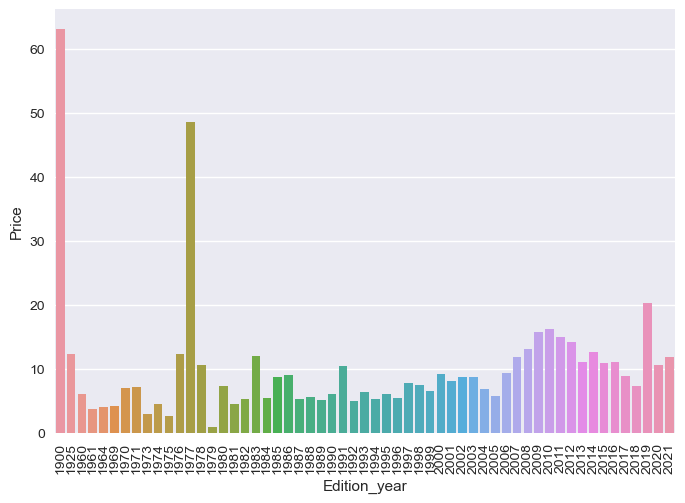

In [33]:
plt.xticks(rotation=90)
sns.barplot(x= df['Edition_year'], y = df['Price'], data=df, ci=None)

In [ ]:
df.drop(columns=['Edition_year'])

Now that the edition column is cleaned I will clean the next column

#### Reviews column  

Let's head the data again to see what we have

In [34]:
df.head()

,Author,Reviews,Ratings,Genre,BookCategory,Price,Edition_type,Edition_year
0,"Rene Goscinny, Jean Tarbary",5.0 out of 5 stars,1 customer review,Comics & Mangas (Books),Comics & Mangas,2.292,Paperback,2008
1,George R. R. Martin,4.5 out of 5 stars,474 customer reviews,Action & Adventure (Books),"Crime, Thriller & Mystery",4.800,Paperback,2014
2,Eleanor Winters,4.9 out of 5 stars,15 customer reviews,"Handicrafts, Decorative Arts & Crafts (Books)","Arts, Film & Photography",10.500,Paperback,2000
3,Zlatan Ibrahimovic,4.8 out of 5 stars,52 customer reviews,Biographies & Autobiographies (Books),Sports,5.520,Paperback,2013
4,Connelly Clare,4.5 out of 5 stars,2 customer reviews,Romance (Books),Romance,4.776,Paperback,2017


I will use regex to extract the reviews from the reviews column

In [35]:
df['Reviews'] = [re.findall(r'\d+\.\d+', str(i)) for i in df['Reviews']]
df['Reviews'] = df['Reviews'].apply(lambda x: float(x[0]) if len(x)>0 else 0)

In [36]:
df['Reviews'].value_counts().head()

5.0    1134
4.5     613
4.7     600
4.6     555
4.0     521
Name: Reviews, dtype: int64

In [37]:
df['Reviews'].unique()

array([5. , 4.5, 4.9, 4.8, 4.1, 4.4, 3.8, 4.6, 3.9, 4.7, 4.2, 0. , 4. ,
       4.3, 3.7, 2.5, 3.2, 3.4, 2. , 3.5, 3.6, 3.1, 3. , 1. , 2.9, 2.7,
       2.2, 2.4, 2.3, 3.3, 1.5, 2.8, 2.6, 1.4, 1.7, 1.6])

In [38]:
df['Reviews'] = df['Reviews'].apply(lambda x: float(x))

<Axes: xlabel='Reviews', ylabel='Price'>

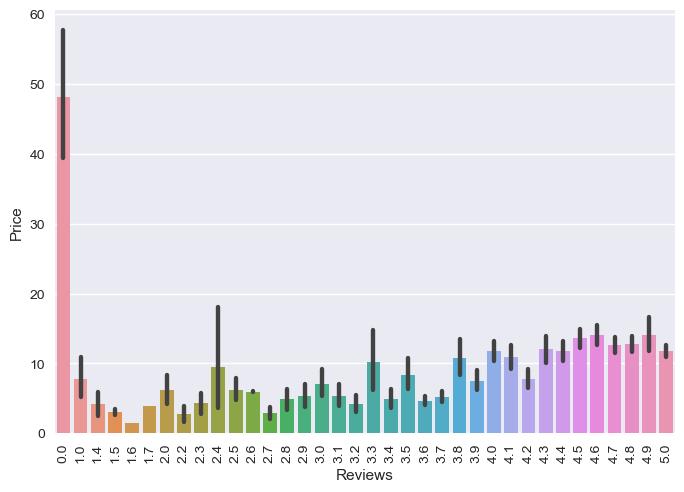

In [39]:
plt.xticks(rotation=90)
sns.barplot(x=df['Reviews'], y = df['Price'], data=df)

Everything looks fine so far

#### Ratings column

Same as the reviews column I will use regex to extract the number of ratings from the ratings column

In [40]:
df['Ratings'] = [re.findall(r'\d+', str(i)) for i in df['Ratings']]
df['Ratings'] = df['Ratings'].apply(lambda x: int(x[0]) if len(x)>0 else 0)

In [41]:
df['Ratings'].value_counts().head()

1    894
2    566
3    396
4    319
5    244
Name: Ratings, dtype: int64

So far so good

#### Genre column

Let's head the data again to see what we have

In [42]:
df.head()

,Author,Reviews,Ratings,Genre,BookCategory,Price,Edition_type,Edition_year
0,"Rene Goscinny, Jean Tarbary",5.0,1,Comics & Mangas (Books),Comics & Mangas,2.292,Paperback,2008
1,George R. R. Martin,4.5,474,Action & Adventure (Books),"Crime, Thriller & Mystery",4.800,Paperback,2014
2,Eleanor Winters,4.9,15,"Handicrafts, Decorative Arts & Crafts (Books)","Arts, Film & Photography",10.500,Paperback,2000
3,Zlatan Ibrahimovic,4.8,52,Biographies & Autobiographies (Books),Sports,5.520,Paperback,2013
4,Connelly Clare,4.5,2,Romance (Books),Romance,4.776,Paperback,2017


Let's check the number of unique values in the genre column

In [43]:
df['Genre'].nunique()

533

There are 532 unique values in the genre column which is a lot so I will drop the column

In [44]:
df.drop(columns=['Genre'], inplace=True)

#### BookCategory column

Let's check the number of unique values in the BookCategory column

In [45]:
df['BookCategory'].nunique()

151

Let's check the value counts in of these values

In [46]:
df['BookCategory'].value_counts().head(15)

Action & Adventure                      634
Crime, Thriller & Mystery               570
Non Fiction                             559
Fiction                                 533
Biographies, Diaries & True Accounts    464
Comics & Mangas                         443
Language, Linguistics & Writing         441
Romance                                 439
Humour                                  421
Arts, Film & Photography                399
Computing, Internet & Digital Media     387
Sports                                  357
Politics                                253
General                                  39
Fantasy                                  37
Name: BookCategory, dtype: int64

Looks like this column hs too many value counts so i will just drop it 

In [47]:
df.drop(columns=['BookCategory'],inplace = True)

Everything looks good so far

#### Author column

Let's see the number of unique values in the author column

In [48]:
df['Author'].nunique()

3449

There are way too many unique values in the author column so I will drop it

In [49]:
df.drop(columns=['Author'], inplace=True)

And now to the last column

### Correlation Matrix Heatmap

C:\Users\Abdul\AppData\Local\Temp\ipykernel_9832\1124359865.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=0.2)


<Axes: >

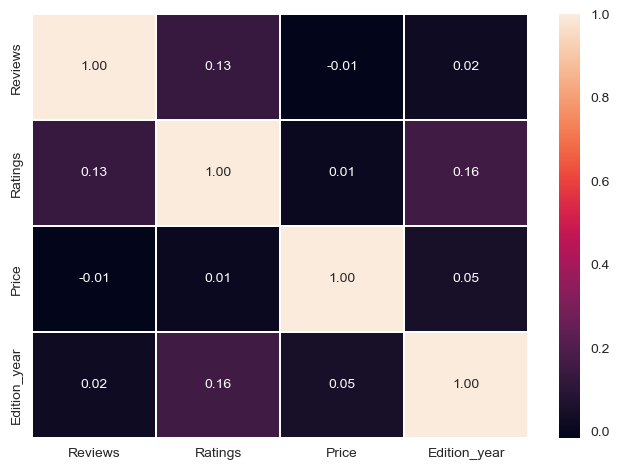

In [50]:
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=0.2)

### Encodind categorical data

For the encoding process we will use one hot encoder. This will transform the categorical variables into numerical variables.

In [51]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False )
arr = ohe.fit_transform(df[['Edition_type']])
transformed_col = pd.DataFrame(arr)
transformed_col.columns = ['Hardcover','Other types','Paperback']
transformed_col

c:\Users\Abdul\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Hardcover,Other types,Paperback
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
6613,0.0,0.0,1.0
6614,1.0,0.0,0.0
6615,0.0,0.0,1.0
6616,0.0,0.0,1.0


Encoded all the categorical values in the Edition type column

In [52]:
df = df.join(transformed_col)
df.drop(columns='Edition_type' , inplace=True)

I joined the encoded columns with the original datafarme and dropped the column

Now let's head the data again and see what we've got.

In [53]:
df.head()

,Reviews,Ratings,Price,Edition_year,Hardcover,Other types,Paperback
0,5.0,1,2.292,2008,0.0,0.0,1.0
1,4.5,474,4.800,2014,0.0,0.0,1.0
2,4.9,15,10.500,2000,0.0,0.0,1.0
3,4.8,52,5.520,2013,0.0,0.0,1.0
4,4.5,2,4.776,2017,0.0,0.0,1.0


### Handeling outliers

We will be handling the outliers in both the Ratings and the Price columns and not the Reviews column as it ranges already from 0 to 5

We will be using the IQR method to handle the outliers. 

First let's visualize the outliers in the these columns using boxplots.

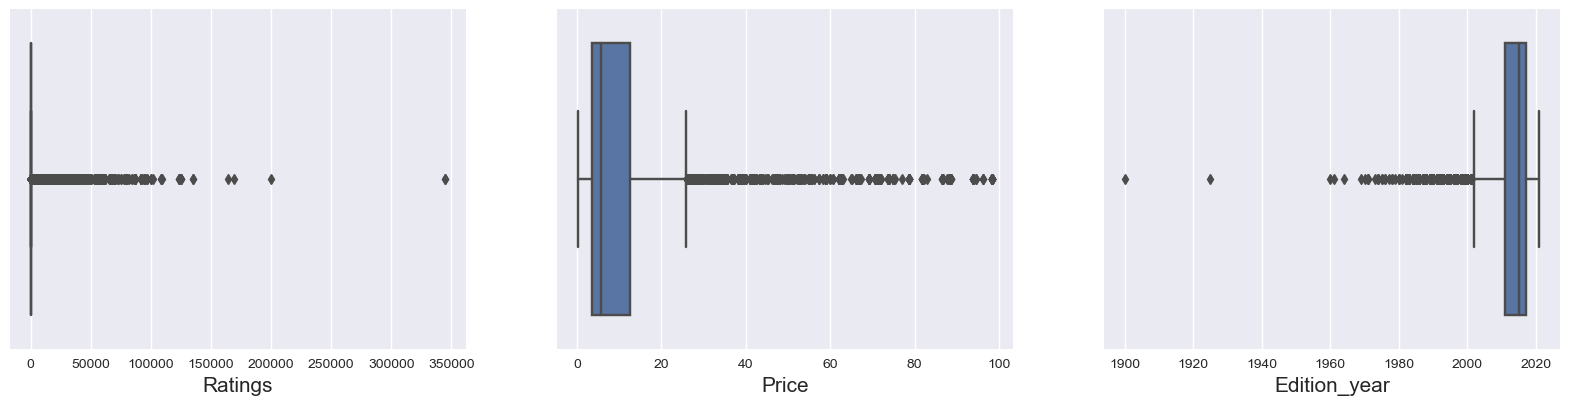

In [54]:
plt.figure(figsize=(20,15))
for i,col in enumerate(df[['Ratings','Price','Edition_year']]):
    plt.subplot(3,3,i+1)
    sns.boxplot(data = df[['Ratings','Price','Edition_year']],x=col)
    plt.xlabel(col, fontsize=15)
    plt.xticks(fontsize=10)

Let's start with the Ratings column

In [55]:
q1 = df['Ratings'].quantile(0.25)
q3 = df['Ratings'].quantile(0.75)
iqr = q3 - q1
lower_whisker = q1 - (1.5*iqr)
upper_whisker = q3 + (1.5*iqr)
df['Ratings'] = df['Ratings'].apply(lambda x: upper_whisker if x > upper_whisker else lower_whisker if x < lower_whisker else x)

And now it's the price column's turn

In [56]:
q1 = df['Price'].quantile(0.25)
q3 = df['Price'].quantile(0.75)
iqr = q3 - q1
lower_whisker = q1 - 1.5 * iqr
upper_whisker = q3 + 1.5 * iqr
df['Price'] = df['Price'].apply(lambda x: upper_whisker if x > upper_whisker else lower_whisker if x < lower_whisker else x)

For the Edition year column , I will not be using the same methode IQR like the other two columns as the year is closer to a categorical variable than a numerical one. I will be using the modes to fill the missing values.

<Axes: xlabel='Edition_year'>

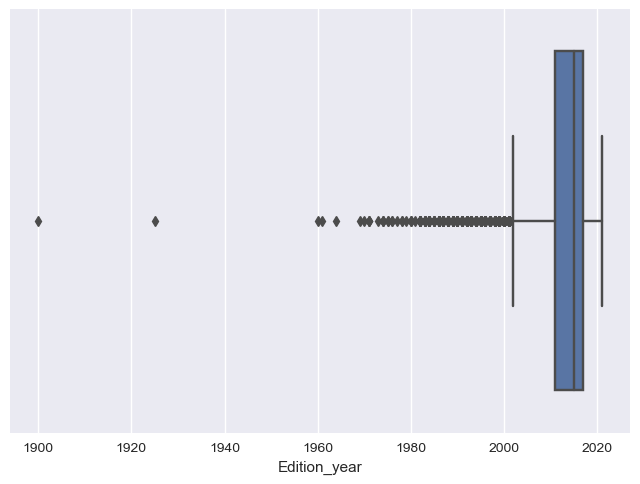

In [57]:
sns.boxplot(x= df['Edition_year'], data=df)

First I will set any year befor 1980 to 1980

In [58]:
df['Edition_year'] = df['Edition_year'].apply(lambda x: 1980 if x < 1980 else x)

Let's see how many data points are smaller than the lower whisker

I will calculate the lower whisker first 

In [59]:
q1 = df['Edition_year'].quantile(0.25)
q3 = df['Edition_year'].quantile(0.75)
iqr = q3 - q1
lower_whisker = q1 - 1.5 * iqr

In [60]:
less_than_min = df[df['Edition_year'] < lower_whisker]
less_than_min.shape

(436, 7)

It turned out that there are not many values less than the lower whisker, let's see the value counts of each year and see where will we go from there 

In [61]:
df['Edition_year'].value_counts().head(20)

2018    755
2017    688
2016    652
2015    578
2019    528
2014    464
2013    429
2012    373
2011    347
2010    323
2009    253
2008    150
2005    103
2007     95
2006     92
2003     81
2020     77
2021     73
2004     68
2000     59
Name: Edition_year, dtype: int64

<Axes: xlabel='Edition_year'>

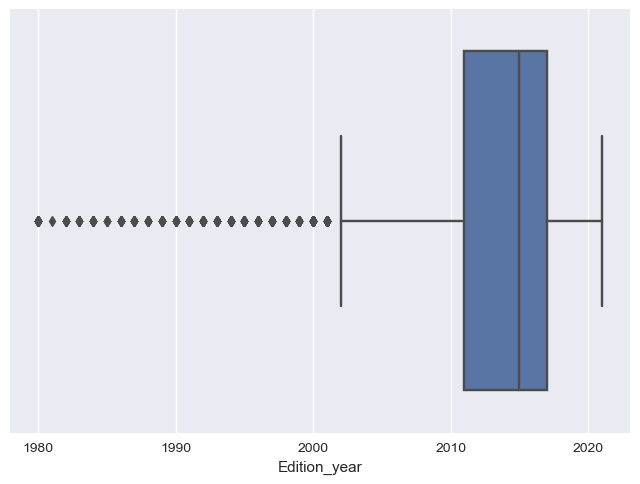

In [62]:
sns.boxplot(x= df['Edition_year'], data= df)

Everything seems fine for now 

Outliers handeled successfully and now to the next step

C:\Users\Abdul\AppData\Local\Temp\ipykernel_9832\544175928.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df['Ratings'], y=df['Price'], data=df, palette='Set1')


<Axes: xlabel='Ratings', ylabel='Price'>

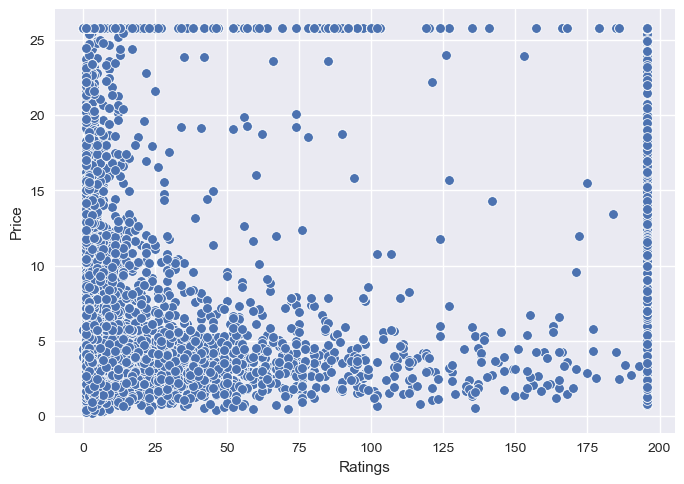

In [63]:
sns.scatterplot(x=df['Ratings'], y=df['Price'], data=df, palette='Set1')

<Axes: xlabel='Price', ylabel='Count'>

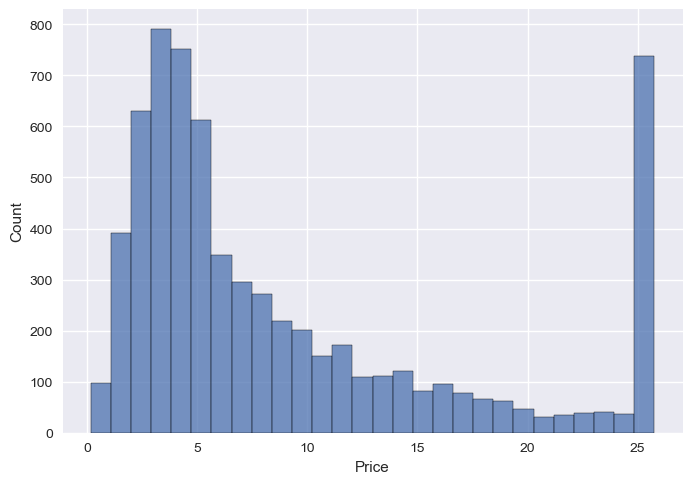

In [64]:
sns.histplot(x = df['Price'], data=df)

## Testing data

First I am going to save the ids of the test data and then drop the id column from the test data.

In [65]:
test_ids = test['ID']

Then I am going to drop the id column along with Title and Synopsis like i did with the training data.

In [66]:
test.drop(columns=['ID','Title','Synopsis'] , inplace=True)

I will do with the test data the same as I did with the training data..

### Data cleaning

#### Edition column

In [67]:
test[['Edition_type', 'Edition_year']] = test['Edition'].str.split(' ',1, expand=True)

C:\Users\Abdul\AppData\Local\Temp\ipykernel_9832\2038780738.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  test[['Edition_type', 'Edition_year']] = test['Edition'].str.split(' ',1, expand=True)


In [68]:
test['Edition_type'] = [re.sub(r'[^a-zA-Z]', '', i) for i in test['Edition_type']]

In [69]:
test['Edition_year'] = [re.findall(r'(\d+)(?!.*\d)', str(i)) for i in test['Edition_year']]
test['Edition_year'] = test['Edition_year'].apply(lambda x: int(x[0]) if len(x)>0 else 0)

In [70]:
test.drop(columns=['Edition'], inplace=True)

In [71]:
test[['Edition_type', 'Edition_year']].isnull().sum()

Edition_type    0
Edition_year    0
dtype: int64

In [72]:
test['Edition_type'].value_counts().head()

Paperback    1329
Hardcover     294
Oct            48
Mass           42
Jan            34
Name: Edition_type, dtype: int64

In [73]:
types = ['Paperback','Hardcover']
test['Edition_type'] = test['Edition_type'].apply(lambda x: 'Others' if x not in types else x)

In [74]:
test['Edition_year'] = [2018 if i == 0 else i for i in test['Edition_year']]

In [ ]:
df.drop(columns=['Edition_year'])

#### Review column

In [75]:
test['Reviews'] = [re.findall(r'\d+\.\d+', str(i)) for i in test['Reviews']]
test['Reviews'] = test['Reviews'].apply(lambda x: float(x[0]) if len(x)>0 else 0)

#### Ratings column

In [76]:
test['Ratings'] = [re.findall(r'\d+', str(i)) for i in test['Ratings']]
test['Ratings'] = test['Ratings'].apply(lambda x: int(x[0]) if len(x)>0 else 0)

#### Genre column

In [77]:
test.drop(columns=['Genre'], inplace=True)

#### Bookcategory column

In [78]:
test.drop(columns=['BookCategory'], inplace=True)

#### Author column

In [79]:
test.drop(columns=['Author'], inplace=True)

### Encoding categorical data

In [80]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False )
arr = ohe.fit_transform(test[['Edition_type']])
transformed_col = pd.DataFrame(arr)
transformed_col.columns = ['Hardcover','Other types','Paperback']
transformed_col

c:\Users\Abdul\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Hardcover,Other types,Paperback
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
...,...,...,...
1995,0.0,0.0,1.0
1996,0.0,0.0,1.0
1997,0.0,0.0,1.0
1998,1.0,0.0,0.0


In [81]:
test = test.join(transformed_col)
test.drop(columns='Edition_type' , inplace=True)

### Handling outliers

In [82]:
q1 = test['Ratings'].quantile(0.25)
q3 = test['Ratings'].quantile(0.75)
iqr = q3 - q1
lower_whisker = q1 - (1.5*iqr)
upper_whisker = q3 + (1.5*iqr)
test['Ratings'] = test['Ratings'].apply(lambda x: upper_whisker if x > upper_whisker else lower_whisker if x < lower_whisker else x)

In [83]:
test['Edition_year'] = df['Edition_year'].apply(lambda x: 1980 if x < 1980 else x)

### Splitting the data

In [84]:
x = df.drop(['Price'], axis=1)
y = df['Price']
print(f'x shape = {x.shape}')

x shape = (6618, 6)


### Data scaling

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)
test = scaler.transform(test) 

Both the training and test data are now scaled

## Modeling


- Linear Regression
- Decision Tree
- Random Forest
- Gradient Boosting
- XGBoost

### Linear regression

In [86]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x, y)

LinearRegression()

### Desicion Trees regressor

In [87]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(x,y)

DecisionTreeRegressor()

### Random forest regressor

In [88]:
from sklearn.ensemble import RandomForestRegressor
rnf_reg = RandomForestRegressor(n_estimators = 1500, 
                                max_depth = 10, 
                                min_samples_split = 7, 
                                min_samples_leaf = 4,
                                max_features = 'auto', 
                                random_state = 42, 
                                verbose = 1)
rnf_reg.fit(x, y)

c:\Users\Abdul\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    8.6s finished


RandomForestRegressor(max_depth=10, max_features='auto', min_samples_leaf=4,
                      min_samples_split=7, n_estimators=1500, random_state=42,
                      verbose=1)

### Gradian Boosting Regressor

In [89]:
from sklearn.ensemble import GradientBoostingRegressor
gdb_reg = GradientBoostingRegressor()
gdb_reg.fit(x,y)

GradientBoostingRegressor()

### XGB regressor

In [90]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Now I will test the accuracy of each model using cross validation

### Testing train accuracy

In [91]:
from sklearn.model_selection import cross_val_score

scores_lin = cross_val_score(lin_reg, x, y, scoring= 'neg_root_mean_squared_error', cv = 5)

scores_tree = cross_val_score(tree_reg, x, y, scoring= 'neg_root_mean_squared_error', cv = 5)

scores_rnf = cross_val_score(rnf_reg, x, y, scoring= 'neg_root_mean_squared_error', cv = 5)

scores_gdb = cross_val_score(gdb_reg, x, y, scoring= 'neg_root_mean_squared_error', cv = 5)

scores_xgb = cross_val_score(xgb_reg, x, y, scoring= 'neg_root_mean_squared_error', cv = 5)


c:\Users\Abdul\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    0.2s finished
c:\Users\Abdul\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn

In [92]:
print(f'Linear regression negative root mean squared error = {scores_lin.mean()}')
print(f'Decision tree negative root mean squared error = {scores_tree.mean()}')
print(f'Random forest negative root mean squared error = {scores_rnf.mean()}')
print(f'Gradiantboost regressor negative root mean squared error = {scores_gdb.mean()}')
print(f'XGB regressor negative root mean squared error = {scores_xgb.mean()}')

Linear regression negative root mean squared error = -6.232039854977279
Decision tree negative root mean squared error = -6.0650845142538135
Random forest negative root mean squared error = -5.363316733257127
Gradiantboost regressor negative root mean squared error = -5.617563130042389
XGB regressor negative root mean squared error = -5.308176099254835


As it's shown in the cell above the best two models are RandomForestRegressor and XGBRegressor.

I will perform some hyperparameter tuning on both of them and then I will choose the best one or maybe I will combine them.

### Ensambeling best models

In [93]:
final_prediction = (xgb_reg.predict(test)+rnf_reg.predict(test))/2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    0.4s finished


In [94]:
final = pd.DataFrame({'ID':test_ids.values, 'Price': final_prediction})

In [95]:
final.to_csv('Final predictions.csv',index=False)